In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn

from scipy.stats import zscore

In [2]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    print("CUDA NOT supported")

CUDA is supported


In [3]:
# load wav file into 1-D ndarray
from scipy.io import wavfile

fname = "./data/01_16K.wav"
fs, data = wavfile.read(fname)

# data = zscore(data) # normalize data

print(fs, data.shape)

16000 (2721750,)


/home/tsparkle/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [4]:
# do STFT on wav file
from scipy.signal import stft

# This is enough for 8KHz audio samples, judging by hearing tests
stft_sample_rate = 100

# Note: we use the input audio's sample rate as the window size, as it's just enough to capture 
#       all frequencies in the waveform without making the window too large. 
#       Hearing tests seem to support this. 
f, t, zxx_c = stft(data, fs=fs, nperseg=fs, noverlap=fs*(1-1/stft_sample_rate))
print(zxx_c.shape)

# break out and concat real and imaginary parts
zxx = np.vstack((np.real(zxx_c), np.imag(zxx_c)))

print(zxx.shape)

(8001, 17012)
(16002, 17012)


In [5]:
batch_size= 4
chunk_size = 100  # 1s sample

# use 1-second silence as the delimiter between music pieces
data_delim = np.zeros((zxx.shape[0],stft_sample_rate))
# input-teacher padding for LSTM
xt_padding = np.zeros((zxx.shape[0],1))

# make raw train and teacher sets from STFT'd data
X = np.hstack((xt_padding, zxx)).transpose()
T = np.hstack((zxx, xt_padding)).transpose()
print(X.shape, T.shape)
assert (X[1:] == T[:-1]).all()

# pad X and T to nearest multiple of batch_size*chunk_size
max_pad_len = batch_size * chunk_size
X = np.vstack((X, np.zeros((max_pad_len - X.shape[0] % max_pad_len, X.shape[1]))))
T = np.vstack((T, np.zeros((max_pad_len - T.shape[0] % max_pad_len, T.shape[1]))))

# create minibatchs
X = torch.FloatTensor(X).view(batch_size, -1, zxx.shape[0]).transpose(0,1)
T = torch.FloatTensor(T).view(batch_size, -1, zxx.shape[0]).transpose(0,1)

print(X.shape, T.shape)

(17013, 16002) (17013, 16002)
torch.Size([4300, 4, 16002]) torch.Size([4300, 4, 16002])


In [6]:
from lstm import LSTMBasic, LSTMFC

model = LSTMBasic(zxx.shape[0], 2048, num_layers=1, batch_size=batch_size)
# model = LSTMFC(zxx.shape[0], 2048, num_layers=1, batch_size=batch_size, dropout_p=0.2)

model = model.to(computing_device)
criterion = nn.MSELoss().to(computing_device)

dp = nn.DataParallel(model, dim=1).to(computing_device)
m = dp.module

optimizer = torch.optim.Adam(dp.parameters(), lr=0.002)

In [7]:
%%time 

n_epochs = 100
num_chunks = X.shape[0]//chunk_size

train_loss = []

m.train()
for epoch in range(n_epochs):
    
    # wipe model states before every epoch
    m.curr_state = m.init_hidden()
    
    epoch_losses = []
    for i in range(0, num_chunks):

        optimizer.zero_grad()

        chunk = X[i*chunk_size:(i+1)*chunk_size].to(computing_device)
        teacher = T[i*chunk_size:(i+1)*chunk_size].to(computing_device)

        out, _ = dp(chunk, m.curr_state)

        loss = criterion(out, teacher)
        epoch_losses += [loss.item()]

        loss.backward()
        optimizer.step()

        m.curr_state[0].detach_()
        m.curr_state[1].detach_()
        
        ic = int(i * 30 / num_chunks) + 1
        ie = int(epoch * 30 / n_epochs)+1
        print("Epoch {:04d} [{}{}]{:05.1f}% Chunk {:03d} [{}{}]{:05.1f}% cLoss:{:f}"\
              .format(epoch+1, "#"*ie, '_'*(30-ie), epoch/n_epochs*100, 
                      i+1, '#'*ic, '_'*(30-ic), i/num_chunks*100, loss.item()), end='\r')

    train_loss += [epoch_losses]
    
print() # prevent %%time from overwriting the progress bar

KeyboardInterrupt: 

In [8]:
save_model = False
if save_model:
    torch.save(model.state_dict(), "e{}.ckpt".format(epoch+1))

In [9]:
# generate sample

m.eval()

with torch.no_grad():

    m.curr_state = m.init_hidden()
    
    eval_output = []
    
    # prime the model with 10 seconds of input
    primer = torch.FloatTensor(zxx.transpose())
    primer = primer[:10*stft_sample_rate].view(-1, 1, zxx.shape[0]).to(computing_device)    
    out, _ = dp(primer, m.curr_state)
    eval_output += [out.cpu().numpy()]

#     # starter 
#     out = torch.zeros((1, 1, zxx.shape[0])).to(computing_device)
    
#     # start generation 
#     for i in range(10 * stft_sample_rate):
#         print("{}/{}".format(i+1,10 * stft_sample_rate), end='\r')
#         out, _ = dp(out, m.curr_state)
#         eval_output += [out.cpu().numpy()]

In [10]:
# assemble the output matrix
eval_output = np.array(eval_output[:]).reshape(zxx.shape[0],-1)
print(eval_output.shape, zxx.shape)

# reassemble real and imaginary parts of the output
eval_out_ra = eval_output[:int(zxx.shape[0]/2)] + 1j * eval_output[int(zxx.shape[0]/2):]
print(eval_out_ra.shape)

(16002, 1000) (16002, 25957)
(8001, 1000)


In [11]:
# iSTFT
from scipy.signal import istft
t, x = istft(eval_out_ra, fs=fs, nperseg=fs, noverlap=fs*(1-1/stft_sample_rate))
print(x.shape)

# normalize iSTFT outputs! the raw data make insanely loud audio
# Note: 0.05 is a good scaling value empirically 
x = zscore(x)*0.1

(159840,)


In [ ]:
plt.specgram(x, Fs=fs, NFFT=fs, noverlap=fs*(1-1/stft_sample_rate))
plt.show()

In [ ]:
write_wav = True
if write_wav:
    wavfile.write("2.wav", fs, x)

In [ ]:
raise Exception

# random tests below

In [6]:
temp = T.cpu().numpy().reshape(-1, 16002).transpose()
temp = temp[:8001] + 1j * temp[8001:]
temp.shape

(8001, 17200)

In [8]:
from scipy.signal import istft
t, x = istft(temp[:,:1000], fs=fs, nperseg=fs, noverlap=fs*(1-1/stft_sample_rate))
print(x.shape)

(159840,)


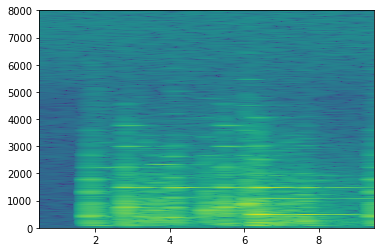

In [9]:
plt.specgram(x, Fs=fs, NFFT=fs, noverlap=fs*(1-1/stft_sample_rate))
plt.show()

In [ ]:
wavfile.write("2.wav", fs, x)